#**Deep Learning Homework 3: Convolutional Neural Networks**

### MSc Computer Science, Data Science, Cybersecurity @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---
In this homework, we will explore how to develop a simple Convolutional Neural Network for image classification. We will use the CIFAR-10 dataset. In the first part, we will learn how to develop a simple CNN, while in the second part we will explore the impact of various hyper-parameters in the learning performances.

##Exercise 3.1: Simple CNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

###Load dataset:
### Load Data: CIFAR-10 dataset


We will use the CIFAR-10 dataset.The dataset consists of 60000 images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. Each sample is a 32x32 pixels color image, associated with a label from 10 classes:

```
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
```

Each pixel intensity is represented by a `uint8` (byte) from 0 to 255.
We will divide the dataset in training, testing and validation set. As you already know, the training set will be used to train the model, the validation set will be used to perform model selection and finally, the test set will be used to asses the performance of deep network.

Since we will use a [2DConv](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) we have to provide also a new dimension of the input that represents the number of channels (that in grey scale image is just one and in color images is 3). Therefore, if you are using grayscale images use [tf.expand_dims](https://www.tensorflow.org/api_docs/python/tf/expand_dims#:~:text=Used%20in%20the%20notebooks,-Used%20in%20the&text=This%20operation%20is%20useful%20to,to%20a%20tensor%20of%20scalars) to transform each image from a matrix to a 3-dimensional tensor. Finally, we have to normalize the input data.

In [2]:
cifar_10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = (
    cifar_10.load_data()) # The dataset is already divede in test and training

# We extract the first 5000 samples of the training set, to use them as the validation set
X_valid, X_train = X_train_full[:5000], X_train_full[5000:] 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]


170508288/170498071 [==============================] - 4s 0us/step


Let's take a look at a sample of the images in the dataset:

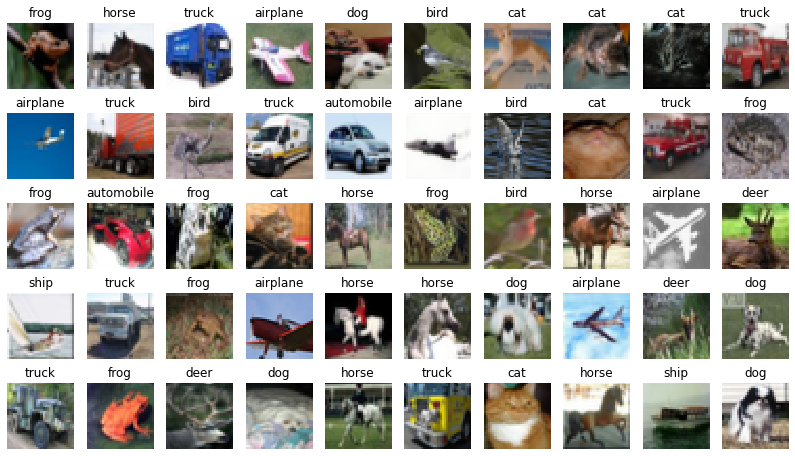

In [3]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index][0]])
plt.show()

### [TO COMPLETE] Input Normalization:

When using Gradient Descent, it is usually a good idea to ensure that all the features have a similar scale. Try to standardize the pixel values.

In [4]:
#[TO COMPLETE]: define X_train_scaled, X_valid_scaled and X_test_scaled, the sets that contains 
#Hint: For each feature (pixel intensity), you must subtract the mean() of that 
#feature (across all instances, so use axis=0) and divide by its standard 
#deviation (std(), again axis=0)


def normalize(dset, mean=None, std=None):
  if mean is None:
    mean = np.sum(dset, axis = 0)/len(dset)
  if std is None:
    std = np.sum(np.square(dset-mean), axis = 0)/len(dset)
  return (dset-mean)/std, mean, std


X_train, X_mean, X_std = normalize(X_train) #[TO COMPLETE]
X_valid,_,_ = normalize(X_valid, X_mean, X_std) #[TO COMPLETE]
X_test,_,_ = normalize(X_test, X_mean, X_std) #[TO COMPLETE]


#Add one dimension to manage the channel if you are using grayscale images.
#X_train=tf.expand_dims(X_train, 3) 
#X_valid=tf.expand_dims(X_valid, 3) 
#X_test=tf.expand_dims(X_test,3)

#Make sure you compute the means and standard deviations on the training set,
#and use these statistics to scale the training set, the validation set and the
# test set

###Define the model

Let's create a simple CNN. The model will be composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2 ([MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D))
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class), and with the "softmax" activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.
Note that as 'input_shape' attribute's value in the first layer report also the third dimension that represents the channel.

In [5]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=[3,3], padding="same", activation="relu", input_shape=[32, 32,3]),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])


Print the model summary

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 10)                81930     
                                                                 
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


Note that the number of parameters mostly depends on the output layers, indeed the parameter sharing techinique used by the 2D convolutional layers allows to significantly reduce the number of learnable weights.
Now we can train the model.

In [7]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
352/352 [==============================] - 33s 92ms/step - loss: 1.8706 - accuracy: 0.3473 - val_loss: 1.7142 - val_accuracy: 0.4070
Epoch 2/10
352/352 [==============================] - 32s 90ms/step - loss: 1.6773 - accuracy: 0.4181 - val_loss: 1.6145 - val_accuracy: 0.4354
Epoch 3/10
352/352 [==============================] - 34s 96ms/step - loss: 1.5860 - accuracy: 0.4538 - val_loss: 1.5518 - val_accuracy: 0.4580
Epoch 4/10
352/352 [==============================] - 32s 92ms/step - loss: 1.4841 - accuracy: 0.4858 - val_loss: 1.4339 - val_accuracy: 0.5032
Epoch 5/10
352/352 [==============================] - 32s 92ms/step - loss: 1.3882 - accuracy: 0.5188 - val_loss: 1.3624 - val_accuracy: 0.5184
Epoch 6/10
352/352 [==============================] - 31s 88ms/step - loss: 1.3209 - accuracy: 0.5415 - val_loss: 1.3135 - val_accuracy: 0.5356
Epoch 7/10
352/352 [==============================] - 31s 89ms/step - loss: 1.2773 - accuracy: 0.5557 - val_loss: 1.2670 - val_accuracy:

Plot the loss and the accuracy trends for the training and validation set. Then, compute the result on the test set.

In [8]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'], label='loss')
  plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
  plt.title('loss')
  plt.legend()
  
def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
  plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
  plt.title('accuracy')
  plt.legend()

''' 
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
'''


' \nplot_loss(history)\n\nplot_accuracy(history)\n\nscores = model.evaluate(X_test, y_test, verbose=2)\nprint("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))\n'

###Visualize Weights

An interesting thing to do is to visualize the learned weights for the convolutional layer. We have 32 kernels of size 3x3, we can just plot them as images, mapping the weight values to grayscale.

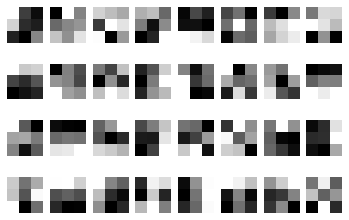

In [9]:
# Weights for the first convolutional layer
w0=model.get_weights()[0][:,:,0,:]

# Normalize to range 0.0 - 1.0
w0-=np.min(w0)
w0/=np.max(w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(w0[:,:,n], interpolation='none')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems that the various filters have learned to detect various corners and edges.

### [TO COMPLETE] Deep CNN
Let's consider a deeper model, more precily in this exercise we consider a model composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2 
* One 2D convolutional layer with kernel size 2x2 and 16 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class), and with the "softmax" activation function


In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=[3,3], activation='relu', input_shape=[32, 32,3]),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    keras.layers.Conv2D(filters=16, kernel_size=[2,2], activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
  ])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
  
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        2064      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 10)               

[TO COMPLETE] Explain in this cell: 

1.   how the number of parameters on each of the two Conv2D layers is determined;
2.   the reasons why the two considered convolutional layers have a different number of parameters.

Answers:


1.   Number of parameters of Conv2D layer is calculated starting from the size of the kernel and the number of "channels" of the input, because the 2D filters need to convolute a 3 dimensional input (3rd dimension is indeed what i called channel). We need to consider that each filter has also a bias weight parameter. Contrary to what it seems weights of the filters are in fact a 4D tensor (See answer 2 for the numbers)
2.   According to answer 1, first Conv2D layer has \[3,3] kernel size (9 weights) applied on 3 channel and 1 bias parameter (9\*3+1 = 28) all multiplied to the number of filters
(28\*32 = 896). Second conv layer recives as input the result of the pooling layer which has dimension (15,15,32). In this case 3rd dimension is 32, number of filters 16 and kernel size \[2,2] so total number of weights is (2\*2\*32 +1)*16 = 2064

Let's now train our deep CNN.

Epoch 1/10
352/352 [==============================] - 33s 92ms/step - loss: 1.9357 - accuracy: 0.3151 - val_loss: 1.7242 - val_accuracy: 0.3914
Epoch 2/10
352/352 [==============================] - 32s 91ms/step - loss: 1.6381 - accuracy: 0.4230 - val_loss: 1.5353 - val_accuracy: 0.4576
Epoch 3/10
352/352 [==============================] - 33s 93ms/step - loss: 1.5069 - accuracy: 0.4678 - val_loss: 1.4617 - val_accuracy: 0.4862
Epoch 4/10
352/352 [==============================] - 33s 92ms/step - loss: 1.4325 - accuracy: 0.4928 - val_loss: 1.3864 - val_accuracy: 0.5108
Epoch 5/10
352/352 [==============================] - 33s 93ms/step - loss: 1.3802 - accuracy: 0.5106 - val_loss: 1.3441 - val_accuracy: 0.5252
Epoch 6/10
352/352 [==============================] - 35s 98ms/step - loss: 1.3472 - accuracy: 0.5267 - val_loss: 1.3301 - val_accuracy: 0.5310
Epoch 7/10
352/352 [==============================] - 34s 95ms/step - loss: 1.3199 - accuracy: 0.5358 - val_loss: 1.3019 - val_accuracy:

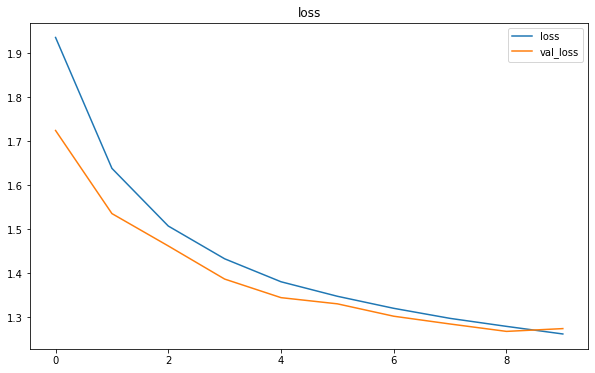

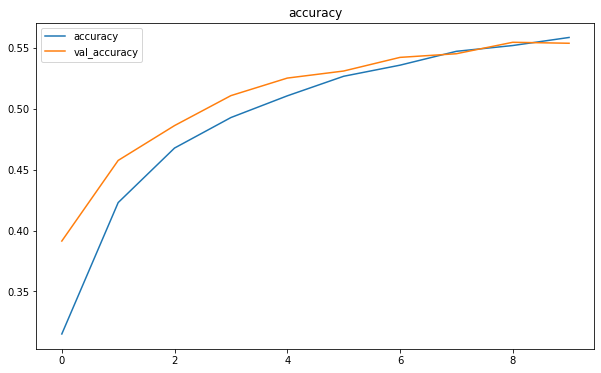

In [11]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128,
                  validation_data=(X_valid, y_valid))

plot_loss(history)
plot_accuracy(history)

scores = model.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("----------------------------")

## [TO COMPLETE] Exercise 3.2: Develop a better CNN
Let's develop a network that performs better than the very simple one above. This exercise aims to explore how much the various hyper-parameters influence the classification capability of the model. 

**[TO COMPLETE]**: Your task is to modify some of the hyper-parameters of the previous exercise's network and compare the results. At least one of the models you try should have an improvement in the test set results (generalization) over the result of the model used in the previous exercise.
In the cell below report only the code of the **best model** that you can find. In addtion, print out its result on the test set, and plot the accuracy and the loss trends in the notebook you return.
Moreover, for each setup you test, analyze and discuss the obtained results briefly in the last cells at the bottom.

Hint: Each reparameterization should change a different aspect in the network, while the rest of the parameters would stay the same. 
Example parameters to try to change (we suggest to test at least one re-parametrization for each of these categories):

*    number of layers or neurons or filters dimension
*   activation functions
*   epochs
*   batch sizes
*   optimizer, see TensorFlow documentation on [optimizers](https://https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
*   max-pooling on/off on certain layers, or pool size

For what concerns the optimizer, as you can see in the 'compile' method [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) is it possible to pass as 'optimizer ' attribute's value a string (the name of optimizer) or an optimizer instance.

Notice that changing the final layer's softmax activation plus the categorical_crossentropy loss requires some consideration. Don't do it unless you have a good plan.

Epoch 1/10
300/300 [==============================] - 95s 314ms/step - loss: 1.8844 - accuracy: 0.3090 - val_loss: 1.6751 - val_accuracy: 0.3914
Epoch 2/10
300/300 [==============================] - 98s 326ms/step - loss: 1.5438 - accuracy: 0.4380 - val_loss: 1.4399 - val_accuracy: 0.4878
Epoch 3/10
300/300 [==============================] - 95s 317ms/step - loss: 1.4040 - accuracy: 0.4928 - val_loss: 1.3317 - val_accuracy: 0.5212
Epoch 4/10
300/300 [==============================] - 96s 320ms/step - loss: 1.3149 - accuracy: 0.5276 - val_loss: 1.2904 - val_accuracy: 0.5352
Epoch 5/10
300/300 [==============================] - 95s 315ms/step - loss: 1.2527 - accuracy: 0.5485 - val_loss: 1.2266 - val_accuracy: 0.5596
Epoch 6/10
300/300 [==============================] - 95s 317ms/step - loss: 1.1997 - accuracy: 0.5731 - val_loss: 1.2128 - val_accuracy: 0.5662
Epoch 7/10
300/300 [==============================] - 94s 315ms/step - loss: 1.1616 - accuracy: 0.5880 - val_loss: 1.1405 - val_ac

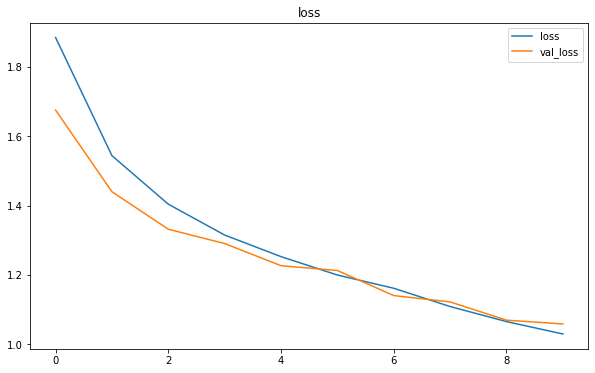

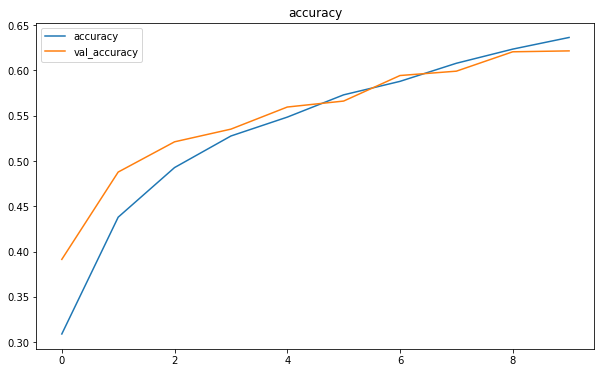

In [15]:
#[TO COMPLETE]

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

params = {
    "kernel":[[3,3],[4,4]],
    "pool":[[2,2],[3,3]],
    "filter":[16,32,64],
    "fc_size":[15,30,45],
    "activation":["relu","sigmoid"]
}

def getModel(kernel,pool,filter,fc_size,activation):
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=filter, kernel_size=kernel, activation=activation, input_shape=[32, 32,3]),
    keras.layers.MaxPool2D(pool_size=pool),
    keras.layers.Conv2D(filters=filter/2, kernel_size=[x-1 for x in kernel], activation=activation),
    keras.layers.MaxPool2D(pool_size=pool),
    keras.layers.Flatten(),
    keras.layers.Dense(fc_size, activation='relu'),
    keras.layers.Dense(10, activation="softmax")
  ])
  model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
  return model


def getModel1(kernel,pool,filter,fc_size,activation):
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=filter, kernel_size=kernel, activation=activation, input_shape=[32, 32,3]),
    keras.layers.MaxPool2D(pool_size=pool),
    keras.layers.Conv2D(filters=filter/2, kernel_size=kernel, activation=activation),
    keras.layers.MaxPool2D(pool_size=pool),
    keras.layers.Flatten(),
    keras.layers.Dense(fc_size, activation='relu'),
    keras.layers.Dense(10, activation="softmax")
  ])
  model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
  return model


def getModel2(kernel,pool,filter,fc_size,activation):
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=filter, kernel_size=kernel, activation=activation, input_shape=[32, 32,3]),
    keras.layers.MaxPool2D(pool_size=pool),
    keras.layers.Conv2D(filters=filter/2, kernel_size=kernel, activation=activation),
    keras.layers.MaxPool2D(pool_size=pool),
    keras.layers.Conv2D(filters=filter/2, kernel_size=kernel, activation=activation),
    keras.layers.MaxPool2D(pool_size=pool),
    keras.layers.Flatten(),
    keras.layers.Dense(fc_size, activation='relu'),
    keras.layers.Dense(10, activation="softmax")
  ])
  model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
  return model  


def getModel3(kernel,pool,filter,fc_size,activation):
  model = keras.models.Sequential([
    keras.layers.Conv2D(padding="same", filters=filter, kernel_size=kernel, activation=activation, input_shape=[32, 32,3]),
    keras.layers.MaxPool2D(pool_size=pool, strides=(2,2)),
    keras.layers.Conv2D(padding="same", filters=filter/2, kernel_size=kernel, activation=activation),
    keras.layers.MaxPool2D(pool_size=pool, strides=(2,2)),
    keras.layers.Conv2D(padding="same", filters=filter/2, kernel_size=kernel, activation=activation),
    keras.layers.MaxPool2D(pool_size=pool),
    keras.layers.Flatten(),
    keras.layers.Dense(fc_size, activation='relu'),
    keras.layers.Dense(fc_size/2, activation='relu'),
    keras.layers.Dense(10, activation="softmax")
  ])
  model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
  return model

def getModel4(kernel,pool,filter,fc_size,activation):
  model = keras.models.Sequential([
    keras.layers.Conv2D(padding="same", filters=filter, kernel_size=kernel, activation=activation, input_shape=[32, 32,3]),
    keras.layers.MaxPool2D(pool_size=pool, strides=(2,2)),
    keras.layers.Conv2D(padding="same", filters=filter/2, kernel_size=kernel, activation=activation),
    keras.layers.MaxPool2D(pool_size=pool, strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(fc_size, activation='relu'),
    keras.layers.Dense(fc_size/2, activation='relu'),
    keras.layers.Dense(10, activation="softmax")
  ])
  model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
  return model

'''
keras_reg = KerasRegressor(build_fn=getModel)
grid_search = GridSearchCV(keras_reg, params, verbose=4, cv=2)

grid_search.fit(X_train, y_train, epochs=5, batch_size=1, verbose=4,
                validation_data=(X_valid, y_valid))

print(grid_search.best_params_)

model = grid_search.best_estimator_.model
model.evaluate(X_test, y_test)
'''

#model = getModel([3,3],[2,2],64,45,"relu") #loss: 1.1009 - accuracy: 0.6152
#model = getModel1([3,3],[2,2],64,45,"relu") #loss: 1.0835 - accuracy: 0.6186
#model = getModel2([3,3],[2,2],64,45,"relu") #loss: 1.0523 - accuracy: 0.6298
#model = getModel3([5,5],[2,2],64,45,"relu") #loss: 0.9666 - accuracy: 0.6628
model = getModel4([3,3],[2,2],64,40,"relu") #loss: 1.0298 - accuracy: 0.6364

history = model.fit(X_train, y_train, epochs=10, batch_size=150,
                  validation_data=(X_valid, y_valid))

plot_loss(history)
plot_accuracy(history)

scores = model.evaluate(X_test, y_test, verbose=2)
print(" %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("----------------------------")


### [TO COMPLETE] Example of tests discussion
The best model that I found (model 3) consists in:
* 3 convolutional layers with activation ReLu, padding and kernel size (5,5) with a number of filter of 64, 32 and 32.
* 3 Max Pooling layers with size (2,2) and stride (2,2).
* 2 Fully connected layers with size 45 and 22.
* 1 final dense layer with softmax.

Batch size 150, optimizer "Adam", 20 epochs.

The achieved accuracy in the test set is 0.6628
the loss min on the test set is 0.9666

Discussion:

Seems like majority of the differences involves the number of layer and the complexity of the model, but fully connected layers at the end doesn't introduce much improvement. I think the goal is to find the correct way to set up the convulution part which i guess is the most important part in developing image-based classification.


Besides, I tested also other models,which are a combination of convolution, max pool and dense layer with different parameters. 
* First model consists in 2 Conv ((3,3),(2,2)) with 64 and 32 filters, 2 Pool (2,2) and one dense (45).
* Second model is similar to the first one but with kernel size of (3,3) in each layer
* Third model First model consists in 3 Conv (3,3) with 64,32 and 32 filters, 3 Pool (2,2) and one dense (45).
* Last model is similar to the best one ( model 3 ) but with only 2 conv/pool layers
